# Google Stock Price LSTM
### By Mojisoluwa Awe

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
import torch
from torch import nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm.notebook import tqdm

In [83]:
df = pd.read_csv('GOOGL_2004-08-01_2024-12-18.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-08-19,2.502503,2.604104,2.401401,2.511011,2.501941,893181924
1,2004-08-20,2.527778,2.729730,2.515015,2.710460,2.700670,456686856
2,2004-08-23,2.771522,2.839840,2.728979,2.737738,2.727849,365122512
3,2004-08-24,2.783784,2.792793,2.591842,2.624374,2.614895,304946748
4,2004-08-25,2.626627,2.702703,2.599600,2.652653,2.643072,183772044


In [84]:
df['Date'] = pd.to_datetime(df.Date)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5118 entries, 0 to 5117
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5118 non-null   datetime64[ns]
 1   Open       5118 non-null   float64       
 2   High       5118 non-null   float64       
 3   Low        5118 non-null   float64       
 4   Close      5118 non-null   float64       
 5   Adj Close  5118 non-null   float64       
 6   Volume     5118 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 280.0 KB
None


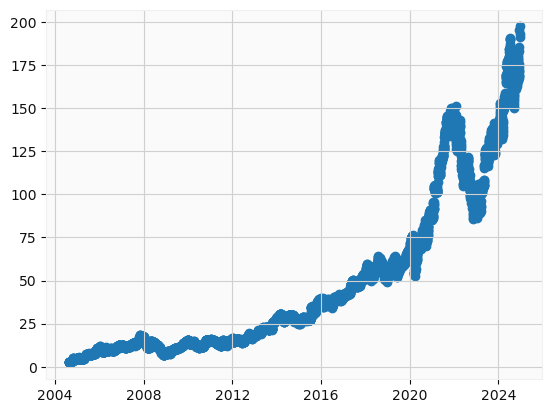

In [85]:
plt.scatter(df['Date'], df['Open'])
plt.show()

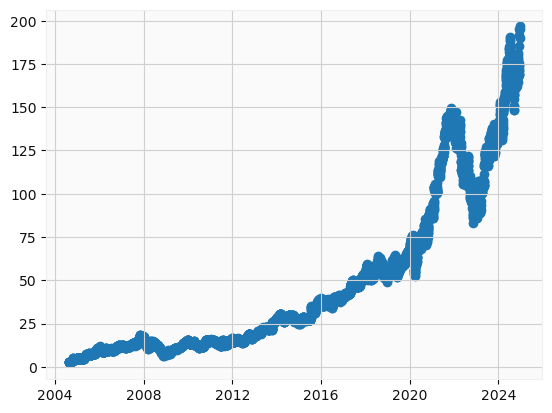

In [86]:
plt.scatter(df['Date'], df['Adj Close'])
plt.show()

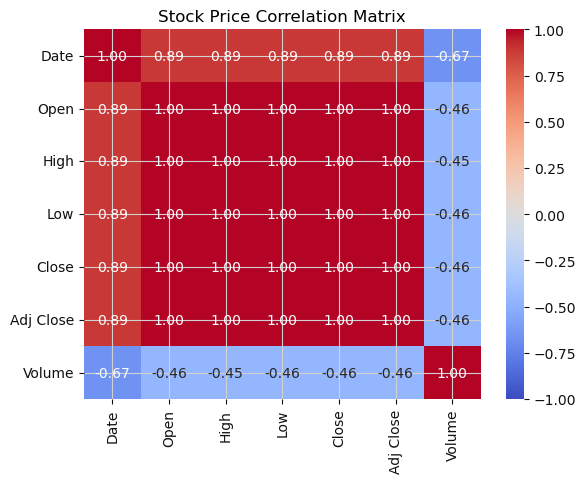

In [87]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', fmt = ".2f", vmin = -1, vmax = 1)
plt.title("Stock Price Correlation Matrix")
plt.show()

/opt/anaconda3/lib/python3.12/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


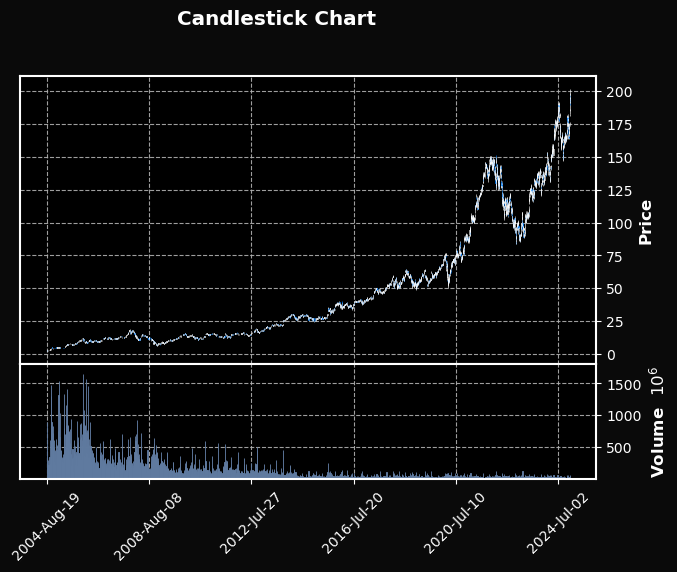

In [88]:
df.set_index('Date', inplace = True)  # Set 'Date' as the index

# Data must have columns: Open, High, Low, Close
mpf.plot(df, type = 'candle', volume = True, title = 'Candlestick Chart', style = 'mike')

In [12]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
5113,2024-12-11,185.309998,195.610001,184.850006,195.399994,195.399994,67894100
5114,2024-12-12,195.000000,195.179993,191.710007,191.960007,191.960007,34817500
5115,2024-12-13,191.009995,192.729996,189.639999,189.820007,189.820007,25143500
5116,2024-12-16,192.869995,199.000000,192.619995,196.660004,196.660004,44934900
5117,2024-12-17,197.250000,201.419998,194.979996,195.419998,195.419998,43482900


In [18]:
df = df.sort_values(by = 'Date')
#df.head()

In [19]:
price_feat = df[['Open', 'High', 'Low', 'Close', 'Adj Close']]
#price_feat[:5]

In [20]:
scaler = MinMaxScaler(feature_range = (-1, 1))
price_feat = scaler.fit_transform(price_feat.values)

In [22]:
#price_feat[:5]

## Testing & Training Set Creation

In [25]:
train_window = 7

def create_in_out_sequences(price, tw):
    inout_seq = []
    L = len(price)
    print('Length:', L)
    
    for i in range(L-tw):
        data_seq = price[i : i+tw]
        data_label = price[i+tw : i+tw+1][0][3]
        inout_seq.append((data_seq, data_label))
    
    data = inout_seq;
    print('size of data: ', len(data))
    
    test_set_size = 1500
    train_set_size = len(data) - test_set_size
    print('size of train: ', train_set_size)
    print('size of test: ', test_set_size)
    
    train = data[:train_set_size]
    test = data[train_set_size:]
    train = train[: -(tw-1)]
    return train, test

train, test = create_in_out_sequences(price_feat, train_window)

Length: 5118
size of data:  5111
size of train:  3611
size of test:  1500


In [28]:
print(test[0])
print(train[-1])

(array([[-0.4956068 , -0.50383192, -0.51543835, -0.5152409 , -0.5170143 ],
       [-0.52010779, -0.51667926, -0.51727139, -0.51862989, -0.52039091],
       [-0.51308915, -0.49841139, -0.50948756, -0.48608925, -0.48796936],
       [-0.49860524, -0.49595255, -0.50203606, -0.48348828, -0.4853779 ],
       [-0.48150798, -0.49047674, -0.48386167, -0.48669188, -0.48856975],
       [-0.48236541, -0.49110021, -0.48851429, -0.48757775, -0.48945236],
       [-0.49809181, -0.49220645, -0.49254382, -0.48257149, -0.48446441]]), -0.49761602665506377)
(array([[-0.47248183, -0.47664889, -0.46829918, -0.47275986, -0.47468868],
       [-0.47320577, -0.47831322, -0.47192367, -0.47285775, -0.47478621],
       [-0.48124099, -0.48671053, -0.48003466, -0.48410121, -0.48598859],
       [-0.48792075, -0.49140696, -0.49703548, -0.49752329, -0.49936156],
       [-0.49460048, -0.49275957, -0.48984364, -0.48837606, -0.49024777],
       [-0.48777699, -0.48470423, -0.49558154, -0.49247071, -0.49432745],
       [-0.4

## Building the LSTM

In [38]:
class LSTM(nn.Module):
    def __init__(self, input_size = 5, hidden_layer_size = 100, output_size = 1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        
        self.lstm = nn.LSTM(input_size, hidden_layer_size)
        
        self.linear = nn.Linear(hidden_layer_size, output_size)
    
    def forward(self, input_seq):
        hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                      torch.zeros(1, 1, self.hidden_layer_size),
                      )
        lstm_out, hidden_cell = self.lstm(input_seq.view(len(input_seq), 1, -1), hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [39]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

## Model Training

In [40]:
epochs = 4

for i in tqdm(range(epochs)):
    epoch_loss = 0
    for seq, labels in tqdm(train):
        seq = torch.from_numpy(np.array(seq)).type(torch.FloatTensor)
        labels = torch.from_numpy(np.array(labels)).type(torch.FloatTensor)
        
        optimizer.zero_grad()
        
        y_pred = model(seq)
        
        labels = labels.view(1)
        
        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()
        
        epoch_loss += single_loss.item()
    
    average_loss = epoch_loss / len(train)
    print(f'epoch {i:3} loss: {average_loss:.10f}')

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3605 [00:00<?, ?it/s]

epoch   0 loss: 0.0027113544


  0%|          | 0/3605 [00:00<?, ?it/s]

epoch   1 loss: 0.0002111221


  0%|          | 0/3605 [00:00<?, ?it/s]

epoch   2 loss: 0.0002848963


  0%|          | 0/3605 [00:00<?, ?it/s]

epoch   3 loss: 0.0004054496


In [41]:
model.eval()
actual = []
pred = []

for seq, labels in test:
    seq = torch.from_numpy(np.array(seq)).type(torch.FloatTensor)
    labels = torch.from_numpy(np.array(labels)).type(torch.FloatTensor)
    actual.append(labels.item())
    with torch.no_grad():
        pred.append(model(seq).item())

actual = np.array(actual)
pred = np.array(pred)

In [43]:
actual = torch.from_numpy(np.array(actual)).type(torch.Tensor)
pred = torch.from_numpy(np.array(actual)).type(torch.Tensor)

In [45]:
print(pred)
print(actual)

tensor([-0.4976, -0.4705, -0.4716,  ...,  0.9295,  1.0000,  0.9872])
tensor([-0.4976, -0.4705, -0.4716,  ...,  0.9295,  1.0000,  0.9872])


In [48]:
pred_new = scaler.inverse_transform(np.c_[np.zeros(1500), np.zeros(1500), np.zeros(1500), np.zeros(1500), np.array(pred)])
print(pred_new[:, 3])

[99.58137834 99.58137834 99.58137834 ... 99.58137834 99.58137834
 99.58137834]


In [53]:
actual_new = scaler.inverse_transform(np.c_[np.zeros(1500), np.zeros(1500), np.zeros(1500), np.zeros(1500), np.array(actual)])
print(actual_new[:, 3])

[99.58137834 99.58137834 99.58137834 ... 99.58137834 99.58137834
 99.58137834]


In [56]:
print('MAE: ', mean_absolute_error(actual_new, pred_new))
print('RMSE: ', np.sqrt(mean_squared_error(actual_new, pred_new)))

MAE:  0.0
RMSE:  0.0


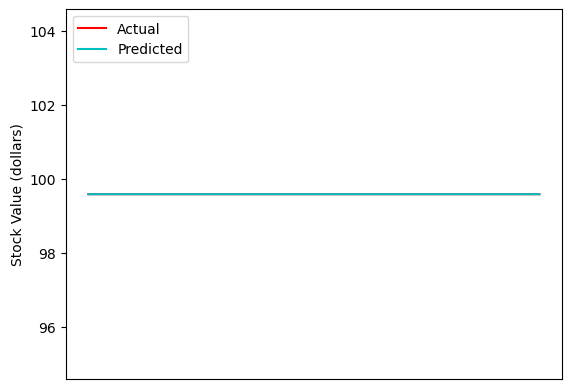

In [57]:
fig, ax = plt.subplots()

ax.plot(actual_new[:,3], 'r-', label='Actual')
ax.plot(pred_new[:,3], 'c-', label='Predicted')

ax.set_ylabel('Stock Value (dollars)')

ax.set_ylim(min(min(actual_new[:,3]), min(pred_new[:,3])) - 5, max(max(actual_new[:,3]), max(pred_new[:,3])) + 5)
plt.xticks([])

ax.legend(loc='upper left')

plt.show()

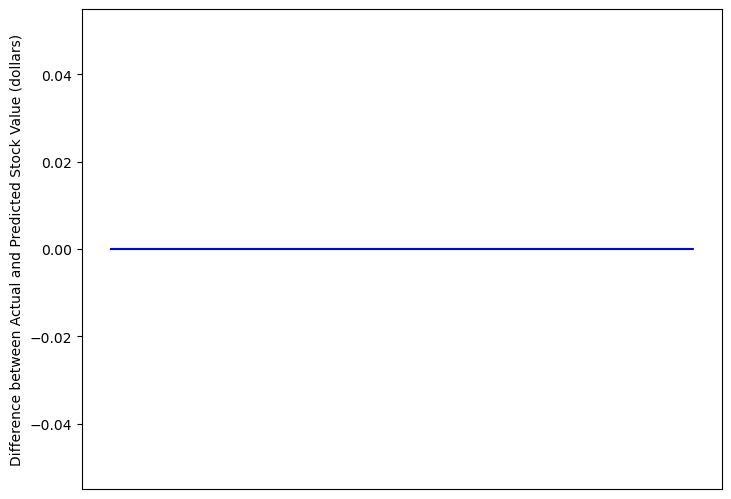

In [58]:
difference = actual_new - pred_new
fig = plt.figure()
diffGraph = fig.add_axes([0,0,1,1])
diffGraph.plot(difference[:, 3], 'b')
diffGraph.set_ylabel('Difference between Actual and Predicted Stock Value (dollars)')
plt.xticks([])
plt.show()